# Classification report : the method of Affinity propagation

### Adrien Bolling, Prateek Gulati, Auriane Jaoui

For this class, we had to try the Affinity propagation method on a dataset of our choice and comment the results as well as the choices made.
We chose to work with a dataset from Kaggle (here's the link : https://www.kaggle.com/datasets/hosseinah1/poker-game-dataset)

This dataset is a collection of poker hands, labeled by a number representing the corresponding "Hand" in poker terms.

All of our data can be considered non-ordinal, so it is a case that may be very hard to solve for algorithms relying on euclidian distances, ill-suited to this kind of problematics, like the Affinity propagation, but it seemed interesting to look at the results of this algorithm in less traditionnal cases.


However, the affinity propagation algorithm is supposed to be efficient in cases of uneven cluster sizes, which is the case here as you'll see below, so we'll see how it handles that.

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.cluster import AffinityPropagation

from sklearn import metrics
from cProfile import label

## Data import

In [118]:
data_raw = pd.read_csv('./data/poker-hand-training.csv')

In [119]:
data_raw.head()

,Suit of Card 1,Rank of Card 1,Suit of Card 2,Rank of Card 2,Suit of Card 3,Rank of Card 3,Suit of Card 4,Rank of Card 4,Suit of Card 5,Rank of Card 5,Poker Hand
0,1,10,1,11,1,13,1,12,1,1,9
1,2,11,2,13,2,10,2,12,2,1,9
2,3,12,3,11,3,13,3,10,3,1,9
3,4,10,4,11,4,1,4,13,4,12,9
4,4,1,4,13,4,12,4,11,4,10,9


In [120]:
hands_map = {
    0 : 'Nothing in hand',
    1 : 'One pair',
    2 : 'Two pairs',
    3 : 'Three of a kind',
    4 : 'Straight',
    5 : 'Flush',
    6 : 'Full house',
    7 : 'Four of a kind',
    8 : 'Straight flush',
    9 : 'Royal flush'}

#### Distribution histograms

array([[<AxesSubplot:title={'center':'Suit of Card 1'}>,
        <AxesSubplot:title={'center':'Rank of Card 1'}>],
       [<AxesSubplot:title={'center':'Suit of Card 2'}>,
        <AxesSubplot:title={'center':'Rank of Card 2'}>],
       [<AxesSubplot:title={'center':'Suit of Card 3'}>,
        <AxesSubplot:title={'center':'Rank of Card 3'}>],
       [<AxesSubplot:title={'center':'Suit of Card 4'}>,
        <AxesSubplot:title={'center':'Rank of Card 4'}>],
       [<AxesSubplot:title={'center':'Suit of Card 5'}>,
        <AxesSubplot:title={'center':'Rank of Card 5'}>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

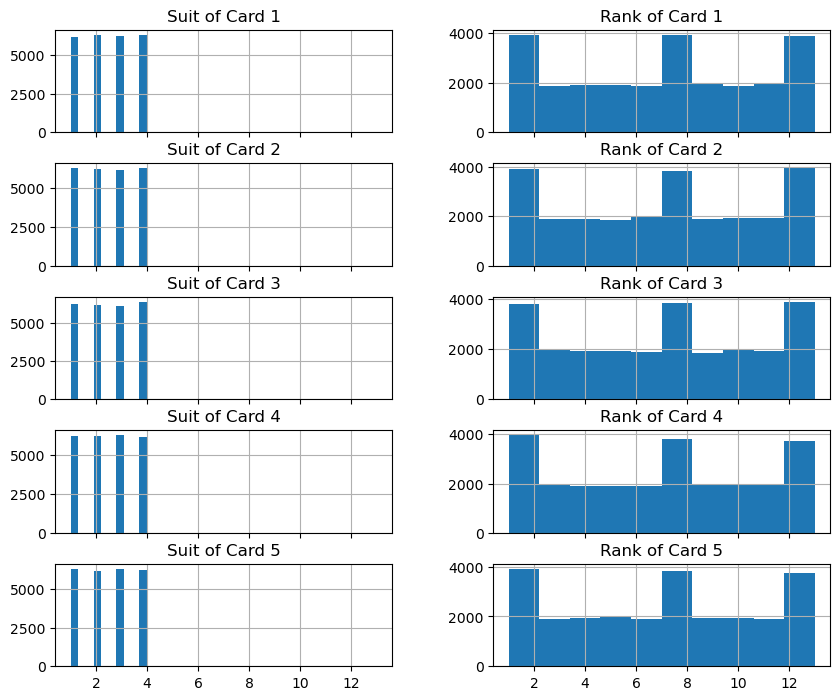

In [121]:
data_raw.drop(columns=['Poker Hand']).hist(sharex=True, figsize=(10,10), layout=(6,2))

<AxesSubplot:>

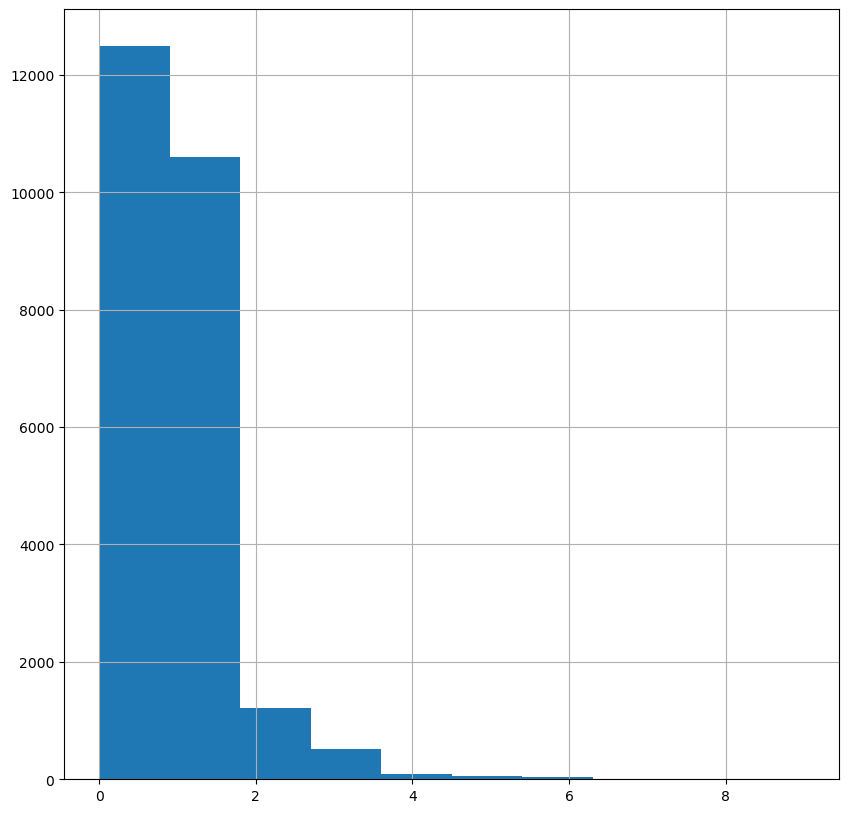

In [122]:
data_raw['Poker Hand'].hist(figsize=(10,10))

#### Correlation matrix

<AxesSubplot:>

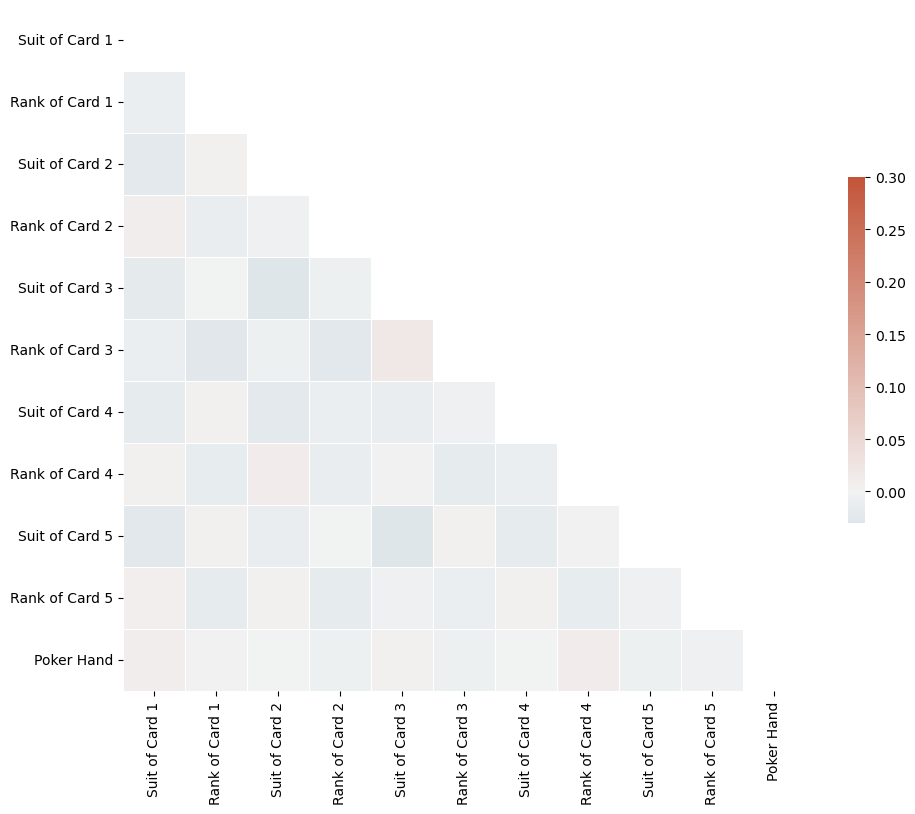

In [123]:
corr = data_raw.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### 2D ACP Projection

In [125]:
acp = PCA()
if True:
    data_ = (data-data.mean(axis=0))/data.std(axis=0)
else:
    data_ = data
acp.fit(data_)
X_pca = acp.transform(data_)
del data_

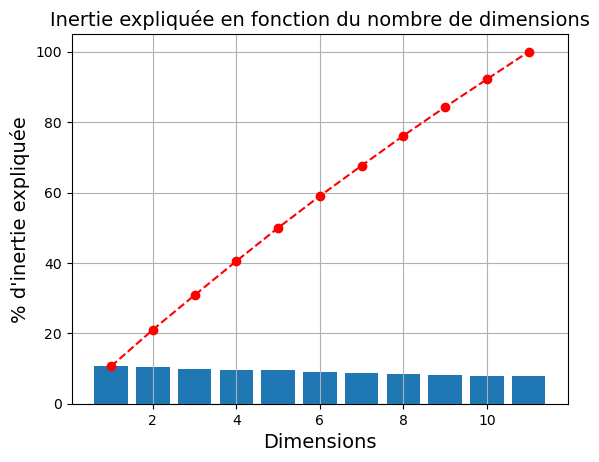

In [126]:
plt.bar(np.arange(len(acp.explained_variance_ratio_))+1,acp.explained_variance_ratio_*100)
plt.plot(np.arange(len(acp.explained_variance_ratio_))+1,np.cumsum(acp.explained_variance_ratio_*100),'r--o')
plt.xlabel("Dimensions",fontsize=14)
plt.ylabel("% d'inertie expliquée",fontsize=14)
plt.title("Inertie expliquée en fonction du nombre de dimensions",fontsize=14);
plt.grid(True)

Looking at the graph above, we can see that using an ACP on this problem will be uterly useless.

#### 2D TSNE Projection

In [143]:
tsne_X = data_raw.drop(columns=['Poker Hand'])
tsne_Y = data_raw['Poker Hand']

# We are using this function in a strange and roundabout way to obtain what we want but it works in the end

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
for train_index, test_index in sss.split(tsne_X,tsne_Y):
    tsne_X, tsne_Y = tsne_X.iloc[test_index], tsne_Y.iloc[test_index]
data_tsne = data_raw.iloc[test_index]


data_ = (data_tsne-data_tsne.mean(axis=0))/data_tsne.std(axis=0)
tsne = TSNE(n_components=2, init='random', random_state=0)
X_tsne = tsne.fit_transform(data_)

<function matplotlib.pyplot.show(close=None, block=None)>

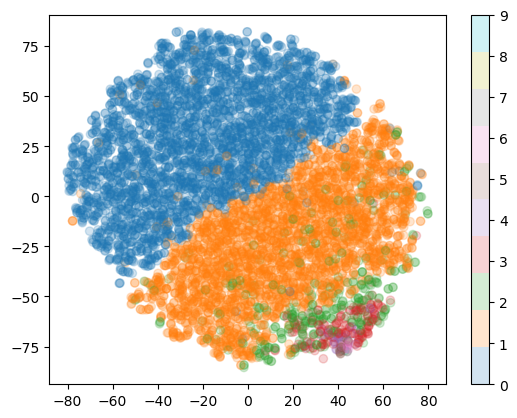

In [146]:
plt.scatter(X_tsne[:,0],X_tsne[:,1], c=data_tsne['Poker Hand'], cmap='tab10', alpha=0.2)
plt.colorbar()
plt.show

### il est possible que nous ayons à ne représenter qu'une partie des données pour que ce soit plus clair, auquel cas il faut faire attention à ce que toutes les classes soient représentées en proportions égales à celles du dataset d'origine.

In the following we'll be working with a reduced dataset because of a lack of RAM to handle the full dataset. We'll only use about 5% of the original dataset, which amounts to around 12000 individuals.
However we'll still be keeping the original proportions, as well as shuffling the data in the process.

In [ ]:
X = data_raw.drop(columns=['Poker Hand'])
Y = data_raw['Poker Hand']

# We are using this function in a strange and roundabout way to obtain what we want but it works in the end

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.05, random_state=0)
for train_index, test_index in sss.split(X,Y):
    X, Y = X.iloc[test_index], Y.iloc[test_index]
data = data_raw.iloc[test_index]

## Classification

Since we have a training set, and a testing set, we need a third validation set in order to preperly evaluate the effects of hyperparameters on our algorithm, however, instead of creating this set artifically, we'll instead use a Cross Validation in order to get rid of the need of a testing set, and our separate testing data will become the validation dataset.

The Cross Validation we'll be using will be a StratifiedShuffleSplit. We chose this one especially because we think that it is important for the algorithm to have each class represented in each learning epoch. the shuffle aspect will help randomize the data, since we don't know how sorted it already is.

The two critical parameters we'll have to discuss will be the damping, and the preference.

The remaining hyperparameter we'll be discussing is the affinity. By default the affinity matrix is computed using the euclidian distance. However it is also possible to provide our algorithm with a pre-computed affinity matrix, using the Manhattan distance for example.

#### Algorithm training

In [129]:
damping = np.arange(0.5,1,0.1)
preference = np.array([-2500, -2000, -1500, -1000, -500, -1])
accuracy_results_raw = []
rand_results_raw = []
fk_results_raw = []


for i,damping_ in enumerate(damping):
    accuracy_res = []
    rand_res = []
    fk_res = []
    for j, preference_ in enumerate(preference):

        accuracy_res_ = []
        rand_res_ = []
        fk_res_ = []
        
        classifier = AffinityPropagation(damping=damping_, random_state=0, preference=preference_)

        sss = StratifiedShuffleSplit(n_splits=3, test_size=0.5, random_state=0)

        for train_index, test_index in sss.split(X,Y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

            classifier.fit(X_train, Y_train)
            predicted_classes = classifier.predict(X_test)
            
            accuracy_res_.append(metrics.accuracy_score(Y_test, predicted_classes))
            rand_res_.append(metrics.adjusted_rand_score(Y_test, predicted_classes))
            fk_res_.append(metrics.fowlkes_mallows_score(Y_test, predicted_classes))
            
        accuracy_res.append(accuracy_res_)
        rand_res.append(rand_res_)
        fk_res.append(fk_res_)
        
    accuracy_results_raw.append(accuracy_res)
    rand_results_raw.append(rand_res)
    fk_results_raw.append(fk_res)

In [130]:
accuracy_results = []
for accuracy_res in accuracy_results_raw:
    temp = []
    for accuracy_res_ in accuracy_res:
        temp.append(np.mean(accuracy_res_))
    accuracy_results.append(temp)

In [131]:
rand_results = []
for rand_res in rand_results_raw:
    temp = []
    for rand_res_ in rand_res:
        temp.append(np.mean(rand_res_))
    rand_results.append(temp)

In [132]:
fk_results = []
for fk_res in fk_results_raw:
    temp = []
    for fk_res_ in fk_res:
        temp.append(np.mean(fk_res_))
    fk_results.append(temp)

<function matplotlib.pyplot.show(close=None, block=None)>

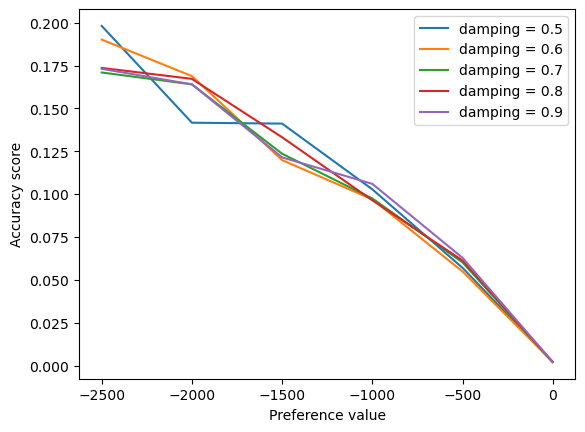

In [133]:
for i,accuracy_res in enumerate(accuracy_results):
    plt.plot([-2500, -2000, -1500, -1000, -500, -1], accuracy_res, label='damping = '+str(round(damping[i], 1)))
plt.xlabel('Preference value')
plt.ylabel('Accuracy score')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

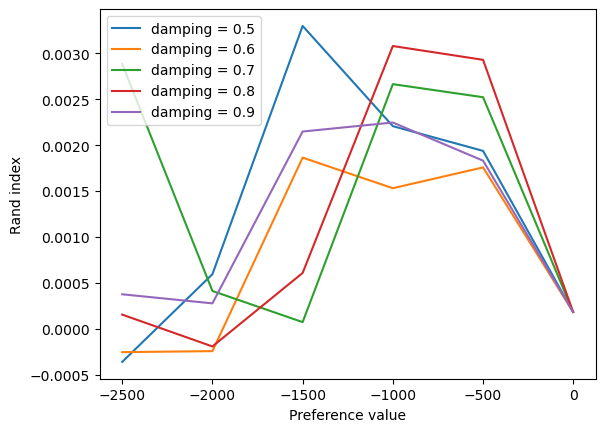

In [134]:
for i,rand_res in enumerate(rand_results):
    plt.plot([-2500, -2000, -1500, -1000, -500, -1], rand_res, label='damping = '+str(round(damping[i], 1)))
plt.xlabel('Preference value')
plt.ylabel('Rand index')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

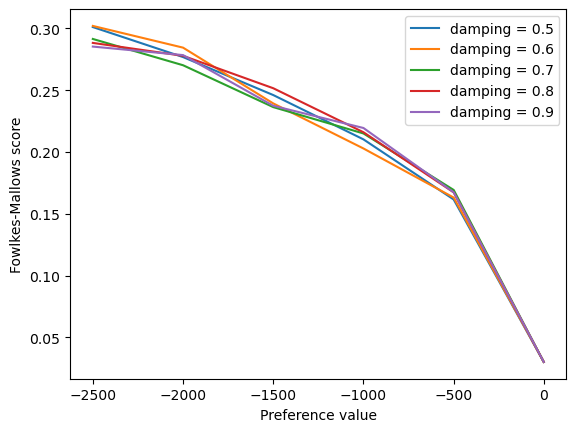

In [135]:
for i,fk_res in enumerate(fk_results):
    plt.plot([-2500, -2000, -1500, -1000, -500, -1], fk_res, label='damping = '+str(round(damping[i], 1)))
plt.xlabel('Preference value')
plt.ylabel('Fowlkes-Mallows score')
plt.legend()
plt.show